In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from math import log

## Original Model

In [2]:
beta = 0.01
k = 4
e = 0.05
size = 50
N = size**2
#T = int(log(N, R))\
T = 2000

In [50]:
counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,4):
    counts[i].append(0)

for t in tqdm(range(T)):
    inf = sum(sum(counts.get(i)) for i in counts.keys())
    for i in range(4):
        new = (beta * (1 - inf) *((1-e)**2*sum(counts.get(i)) + e*(1-e)*sum(counts.get((i+1) % 4)) + 
                                   e*(1-e)*sum(counts.get((i-1) % 4)) + e**2*sum(counts.get((i-2) % 4))))
        counts[i].append(new)

  0%|          | 0/2000 [00:00<?, ?it/s]

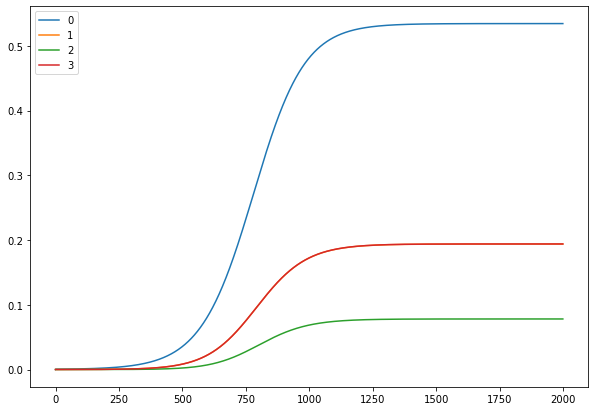

In [51]:
fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), [sum(counts.get(i)[:t]) for t in range(T)], label=f"{i}")
             
plt.legend()
plt.savefig('SI_w_error_2bit_0.05.pdf')

## Matrix-Based Model

In [67]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500

In [68]:
# (this is the two rotation version) B = np.array([(1-e)**2, e*(1-e), e**2, e*(1-e) ])
B = np.array([(1-e), e, 0, e ])

In [69]:
counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,4):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((4,1))
    
    for x in counts.keys():
        Ir = np.concatenate([I[x:],I[:x]]) # permuting the vector 
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B, Ir)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

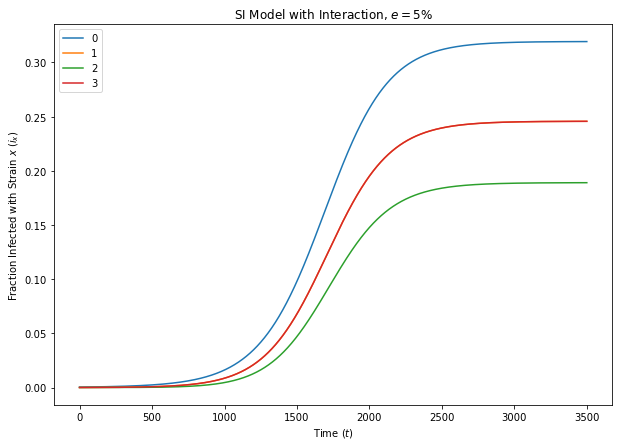

In [70]:
fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

## Generalize to all rotational errors

In [78]:
def ssi(
    B,
    beta = 1/1000,
    k = 4,
    e = 0.5,
    N = 50**2,
    T = 3500,
    bar = True
):
    
    # Add annotations in PyCharm
    
    cts = defaultdict(list)

    cts[0].append(1/N)
    

    for i in range(1,4):

        cts[i].append(0)
    
    if bar:
        pbar = tqdm(range(1,T))
    else:
        pbar = range(1,T)
    
        
    for t in pbar:

        I = np.array([[cts.get(x)[-1]] for x in cts.keys()], dtype=object)
        new = np.zeros((4,1))

        for x in cts.keys():
            Ir = np.concatenate([I[x:],I[:x]]) # permuting the vector 

            di = beta * k * (1 - np.sum(I)) * np.matmul(B, Ir)

            new[x,0] = di
            
        It = I+new
        for x in cts.keys():
            cts[x].append(It[x][0])
            
    return cts

## Testing the Transition

In [80]:
size_diff = list()
for e in tqdm(range(50)):
    err = e/100
    m = ssi(B=np.array([(1-err), err, 0, err]), bar=False)
    final_sizes = [m.get(x)[-1] for x in m.keys()]
    size_diff.append(max(final_sizes)-min(final_sizes))

  0%|          | 0/50 [00:00<?, ?it/s]

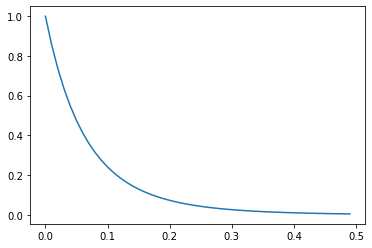

In [81]:
plt.plot([i/100 for i in range(50)], size_diff)

### Reflection error instead of rotation error

In [72]:
flip = ssi(B=np.array([1-e, 0, e, 0]))

  0%|          | 0/3499 [00:00<?, ?it/s]

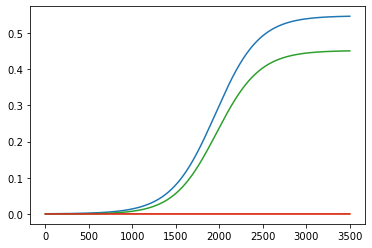

In [73]:
for i in flip.keys():
    plt.plot(range(T), flip.get(i), label=f"{i}")

## Degree Block 

In [72]:
from tqdm import tqdm

In [73]:
m = 2
beta = 0.1
k = 4
e = 0.1
#size = 
N = 100
#T = int(log(N, R))\
T = 100

In [74]:
degrees = np.random.pareto(2,N)
degrees = [int(i)+1  for i in degrees]

In [75]:
degree_counts = Counter(degrees)
deg_counts = Counter(degrees).most_common()

In [76]:
B = np.array([(1-e), e, e, 0])

In [77]:
avgk = np.mean(degrees)

In [78]:
k_dist = np.array([degree_counts[k]/N for k in range(1, max(degrees)+1)])

In [79]:
counts = np.zeros((2**m, max(degrees), T))

# seed this randomly
seed = np.random.randint(N)
counts[0][degrees[seed]][0] = 1/degree_counts.get(degrees[seed])
print(degrees[seed])


    
for t in tqdm(range(1,T)):
    
    I = counts[:, :, t-1] 
    
    if t != 0:
        num_edges = (k-1)
    else:
        num_edges = k
    
    theta = np.array([sum(num_edges*p/N*I[x,k-1] for k,p in deg_counts)/avgk for x in range(counts.shape[0])])
    
    for x in range(counts.shape[0]):
        
        thetar = np.concatenate([theta[x:], theta[:x]]) # permuting the vector 
        
        for k,p in deg_counts:
    
            dik = beta * k * (1 - np.sum(I[:,k-1])) * np.matmul(B, thetar)
            
            counts[x][k-1][t] = counts[x][k-1][t-1] + dik
            

  0%|          | 0/99 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 99/99 [00:00<00:00, 2117.15it/s]

1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


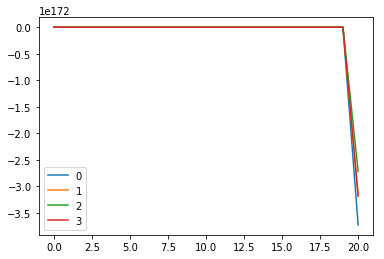

In [80]:
for x in range(4):
    plt.plot(range(T), [np.sum(k_dist*counts[x,:,t]) for t in range(T)], label='%d'%(x))
plt.legend()

## Simulations of Branching Processes

In [6]:
def int_to_bool_array(num, length=None):
    binary_str = bin(num)[2:]  # Convert number to binary string and remove '0b' prefix
    binary_array = np.array(list(map(int, binary_str)))  # Convert binary string to integer array
    
    if length is not None:
        padding = max(length - len(binary_array), 0)
        binary_array = np.pad(binary_array, (padding, 0), mode='constant')[:length]
    
    return binary_array.astype(bool)  # Convert integer array to boolean array

In [7]:
def bool_array_to_int(bool_array):
    binary_str = ''.join(map(str, bool_array.astype(int)))  # Convert boolean array to binary string
    return int(binary_str, 2)  # Convert binary string to integer

In [8]:
def channel(m, e, length=None):
    
    """
    :m: [int] some encoded message which is being passed through this channel 
    :e: [float] error probability of a single bit being flipped
    """
    
    if m > -1:
        m = int_to_bool_array(m, length)

        r = np.random.rand(len(m)) # each bit has probability (1-e) of staying 

        m[(r<=e)] = [not i for i in m[(r<=e)]]
    
    return m

In [9]:
k = 2
n = 1
layer = 0
e = 0.1

nodes = [[3]]

while not n > N:
    
    new_layer = list()
    
    for node in nodes[layer]:
        for _ in range(k):
            m = channel(node, e)
            new_layer.append(bool_array_to_int(m))
    nodes.append(new_layer)
    layer += 1
    n = k*len(nodes[layer])

In [10]:
np.unique(nodes[-1], return_counts=True)

(array([0, 1, 2, 3]), array([509, 501, 441, 597], dtype=int64))

In [11]:
branch_counts = {i: list() for i in range(4)}


for n in tqdm(nodes):
    temp = {i:0 for i in range(4)}
    v,c = np.unique(n, return_counts=True)
    z = zip(v,c)
    for pair in z:
        temp[pair[0]] = pair[1]
        
    for key in temp:
        branch_counts[key].append(temp[key])

  0%|          | 0/12 [00:00<?, ?it/s]

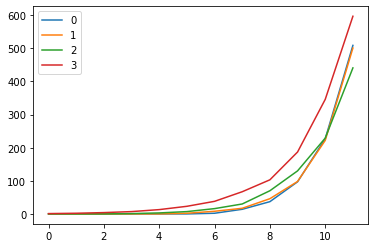

In [12]:
for i in range(4):
    plt.plot(range(len(nodes)), branch_counts.get(i), label=f"{i}")
    
plt.legend()

# Generalizing to m length messages

In [4]:
m = 3
e = 0.05

In [38]:
def poly_gen(m):
    
    if m <= 0:
        raise ValueError("The dimension of the cube must be a positive integer.")

    # Calculate the total number of vertices in the n-cube
    num_vertices = 2**m

    # Initialize an n x n matrix with all zeros
    adjacency_matrix = [[0] * num_vertices for _ in range(num_vertices)]

    # Iterate through all vertices
    for i in range(num_vertices):
        # Iterate through all dimensions
        for j in range(m):
            # Toggle the j-th bit to find the adjacent vertex
            neighbor = i ^ (1 << j)
            adjacency_matrix[i][neighbor] = 1

    return np.array(adjacency_matrix)

In [42]:
def ncube(m):
    
    selfloops = np.eye(2**m)*(1-e)
    polygon = poly_gen(m) * e
    
    return selfloops + polygon

In [ ]:
# single flip

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

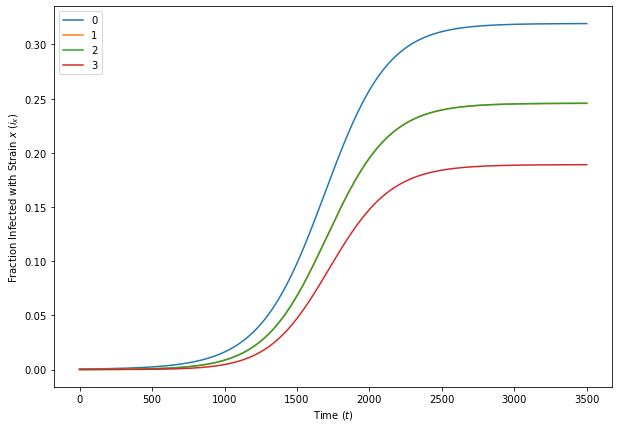

In [50]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m=2

B = ncube(m)

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

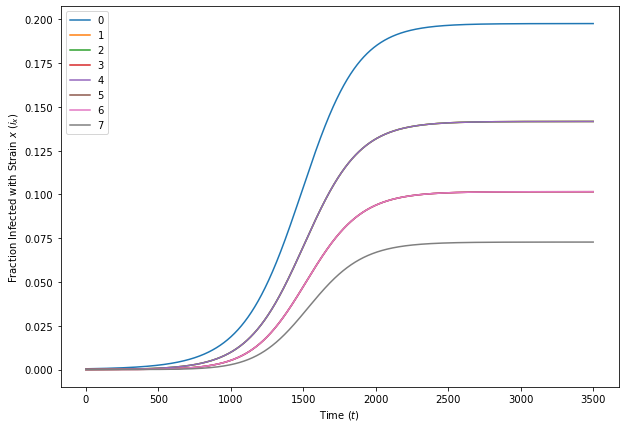

In [51]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m=3

B = ncube(m)

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

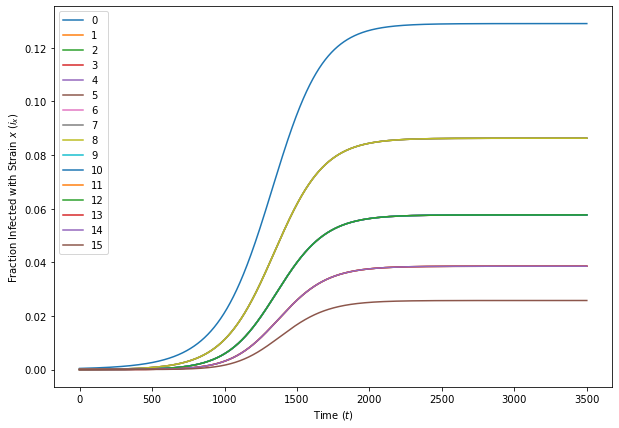

In [49]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m = 4

B = ncube(m)

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

In [ ]:
# can we code this up for compounding error??
# need to change the 0s in the matrix to the appropriate values

# Bit Flip Error

In [137]:
B3 = np.array([[0,1,1,2,1,2,2,3],
               [1,0,2,1,2,1,3,2],
               [1,2,0,1,2,3,1,2],
               [2,1,1,0,3,2,2,1],
               [1,2,2,3,0,1,1,2],
               [2,1,3,2,1,0,2,1],
               [2,3,1,2,1,2,0,1],
               [3,2,2,1,2,1,1,0]])

M = np.zeros((8,8))

for i in range(8):
    for j in range(8):
        M[i,j] = e**B3[i,j] * (1-e)**(m-B3[i,j])

In [138]:
M

array([[0.614125, 0.108375, 0.108375, 0.019125, 0.108375, 0.019125,
        0.019125, 0.003375],
       [0.108375, 0.614125, 0.019125, 0.108375, 0.019125, 0.108375,
        0.003375, 0.019125],
       [0.108375, 0.019125, 0.614125, 0.108375, 0.019125, 0.003375,
        0.108375, 0.019125],
       [0.019125, 0.108375, 0.108375, 0.614125, 0.003375, 0.019125,
        0.019125, 0.108375],
       [0.108375, 0.019125, 0.019125, 0.003375, 0.614125, 0.108375,
        0.108375, 0.019125],
       [0.019125, 0.108375, 0.003375, 0.019125, 0.108375, 0.614125,
        0.019125, 0.108375],
       [0.019125, 0.003375, 0.108375, 0.019125, 0.108375, 0.019125,
        0.614125, 0.108375],
       [0.003375, 0.019125, 0.019125, 0.108375, 0.019125, 0.108375,
        0.108375, 0.614125]])

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

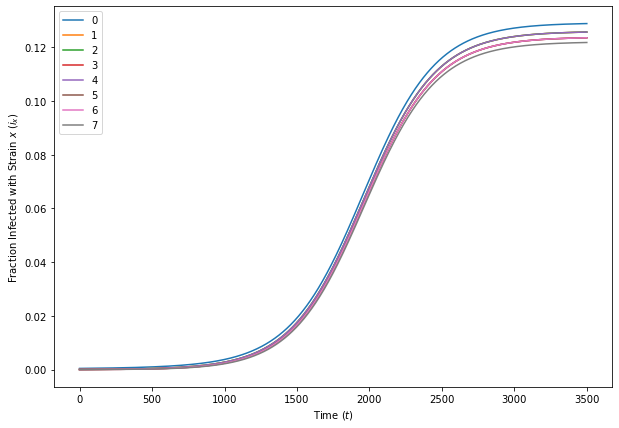

In [147]:
beta = 1/1000
k = 4
e = 0.3
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m=3



M = np.zeros((8,8))

for i in range(8):
    for j in range(8):
        M[i,j] = e**B3[i,j] * (1-e)**(m-B3[i,j])

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(M[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

In [158]:
7 >> 1

3

In [43]:
## What if we don't separate?

N = 10000

def analytic_SI(I, e, beta, k, P):
    
    di = beta * k * (1-np.sum(I)) * ((e*P)@I * I)

    return (e*P)@I

counts = [np.array([1/N,0,0,0])]

T=5
e=0.1
beta = 0.1
k = 4

P = np.array([[0,1,1,0],
             [1,0,0,1],
             [1,0,0,1],
             [0,1,1,0]])

print(analytic_SI(counts[0], e, beta, k, P))


"""
for t in range(1,T):
    counts.append(counts[t-1] + analytic_SI(counts[t-1], e, beta, k, P))
    """
    

[0.e+00 1.e-05 1.e-05 0.e+00]


'\nfor t in range(1,T):\n    counts.append(counts[t-1] + analytic_SI(counts[t-1], e, beta, k, P))\n    '

In [53]:
(0.01)**(P) 

array([[1.  , 0.01, 0.01, 1.  ],
       [0.01, 1.  , 1.  , 0.01],
       [0.01, 1.  , 1.  , 0.01],
       [1.  , 0.01, 0.01, 1.  ]])

In [ ]:
# issue with P here

In [39]:
counts

[array([0.0001, 0.    , 0.    , 0.    ]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.])]

# After all the nonsense

In [2]:
N = 10000
beta = 0.1
T = 100
err = 0.1
avg_k = 4

In [3]:
A = np.array([[0, 1, 1, 0],
             [1, 0, 0, 1],
             [1, 0, 0, 1],
             [0, 1, 1, 0]])
P = (1-err)*np.eye(4) + err/2*A

In [4]:
P

array([[0.9 , 0.05, 0.05, 0.  ],
       [0.05, 0.9 , 0.  , 0.05],
       [0.05, 0.  , 0.9 , 0.05],
       [0.  , 0.05, 0.05, 0.9 ]])

In [5]:
def di(infected, beta, k):
    return beta * k * (1-infected) * infected

In [6]:
def dm(m, infected, beta, k, P):
    return P @ (m * di(infected, beta, k)) 

In [7]:
def dim(infected, beta, k, P):
    return beta * k * (1-sum(infected)) * (P@infected)

In [513]:
def di2(infected, beta, k, P):
    return P @ (beta * k * (infected/sum(infected)-infected))

In [516]:
I = [np.array([1/(N),0,0,0])]


for t in range(1,T):
    I.append(I[t-1] + dim(infected=I[t-1], beta=beta, k=4, P=P))
    
homogenous_entropy = list()
    
for t in range(T):
    d = I[t]
    d = d/sum(d)
    p = d[d > 0]
    h = -np.sum(p*np.log2(p))
    homogenous_entropy.append(h)

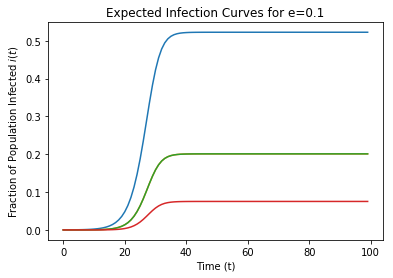

In [517]:
plt.plot(range(T), I)
plt.title('Expected Infection Curves for e=0.1')
plt.ylabel(r'Fraction of Population Infected $i(t)$')
plt.xlabel(r'Time (t)')

plt.savefig('analytic_curves_0.1.pdf')
#plt.legend()

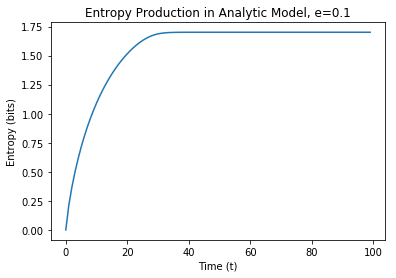

In [10]:
plt.plot(range(T), homogenous_entropy)
plt.title('Entropy Production in Analytic Model, e=0.1')
plt.xlabel('Time (t)')
plt.ylabel('Entropy (bits)')

plt.savefig('analytic_entropy_production.pdf')

In [11]:
analytic_entropies = list()

for i in range(100):
    err_i = i/100
    Pi = (1-err_i)*np.eye(4) + err_i/2*A
    I = [np.array([1/N, 0, 0, 0])]
    for t in range(1,T):
        I.append(I[t-1] + dim(infected=I[t-1], beta=beta, k=4, P=Pi))
    p = I[-1]
    p = p[p > 0]
    h = -np.sum(p * np.log2(p))
    analytic_entropies.append(h)

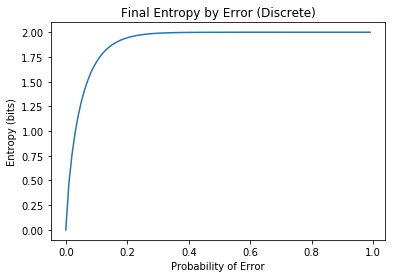

In [12]:
plt.plot([i/100 for i in range(100)], analytic_entropies)
plt.title('Final Entropy by Error (Discrete)')
plt.xlabel('Probability of Error')
plt.ylabel('Entropy (bits)')
plt.savefig('analytic_entropy_by_error.pdf')

In [17]:
P_entropies = [-1 * sum([(1-e)*np.log2(1-e), e/2*np.log2(e/2),e/2*np.log2(e/2)]) for e in [i/100 for i in range(1,100)]]

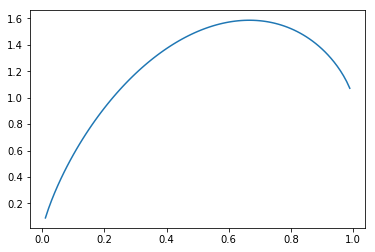

In [18]:
plt.plot([i/100 for i in range(1,100)], P_entropies)

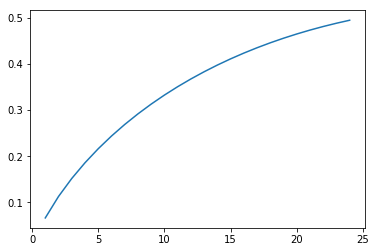

In [83]:
plt.plot(range(1,25), [-1*i/100*np.log2(i/100) for i in range(1,25)])

In [76]:
all_analytic_entropies = list()
all_analytic_phi = list()

for i in range(100):
    err_i = i/100
    Pi = (1-err_i)*np.eye(4) + err_i/2*A
    I = [np.array([1/N, 0, 0, 0])]
    for t in range(1,T):
        I.append(I[t-1] + dim(infected=I[t-1], beta=beta, k=4, P=Pi))
    hlist = list()
    philist = list()
    for j in I:
        #p = j #unnormalized
        p = j/sum(j) # normalized
        p = p[p > 0]
        h = -np.sum(p * np.log2(p))
        hlist.append(h)
        philist.append(p)
    all_analytic_entropies.append(hlist)
    all_analytic_phi.append(philist)

Text(0.5, 1.0, 'Entropy Production by Error Rate')

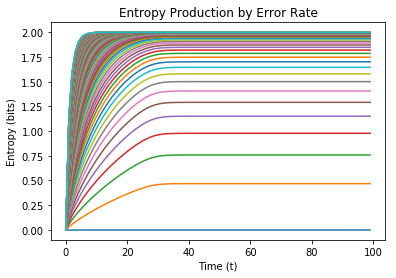

In [77]:
for i in all_analytic_entropies:
    plt.plot(range(100), i)
    
plt.xlabel('Time (t)')
plt.ylabel('Entropy (bits)')
plt.title('Entropy Production by Error Rate')

# Testing Seeds

In [40]:
N = 10000
beta = 0.1
T = 100
err = 0.1
avg_k = 4

In [41]:
A = np.array([[0, 1, 1, 0],
             [1, 0, 0, 1],
             [1, 0, 0, 1],
             [0, 1, 1, 0]])
P = (1-err)*np.eye(4) + err/2*A

In [174]:
def dphi(infected, beta, k,P):
    sumI = sum(infected)
    return beta * k * (1-sumI) * (np.linalg.matrix_power(P,2)-P) @ (infected * sumI**-1)

In [355]:
def dphi_phi(infected, last_phi, beta, k,P):
    sumI = sum(infected)
    #return beta * k * (1-sumI) * (np.linalg.matrix_power(P,2)-P) @ last_phi
    #return beta * k * (1-sumI) * (P-np.eye(P.shape[0])) @ last_phi
    return beta * k * (1-sumI) * (P @ (P-np.eye(P.shape[0]))) @ last_phi

In [356]:
def dphi_I(infected, last_phi, beta, k,P):
    sumI = sum(infected)
    return (P-1) @ last_phi * sumI**-1

In [524]:
phi_t = list()
I = [np.array([1/N,0,0,0])]
anal_phi = [np.array([1,0,0,0])]


for t in range(1,T):
    I.append(I[t-1] + dim(infected=I[t-1], beta=beta, k=4, P=P))
    #anal_phi.append(I[t-1] + dphi(infected=I[t-1], beta=beta, k=4, P=P))
    anal_phi.append(anal_phi[t-1] + dphi_phi(infected=I[t-1], last_phi=anal_phi[t-1], beta=beta, k=4, P=P))
    
homogenous_entropy = list()
    
for t in range(T):
    d = I[t]
    p = d/sum(d)
    #p = d
    phi_t.append(p)

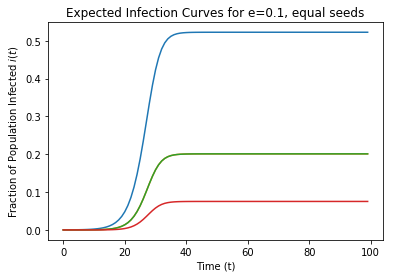

In [525]:
plt.plot(range(T), I)
plt.title('Expected Infection Curves for e=0.1, equal seeds')
plt.ylabel(r'Fraction of Population Infected $i(t)$')
plt.xlabel(r'Time (t)')

plt.savefig('analytic_curves_0.1.pdf')
#plt.legend()

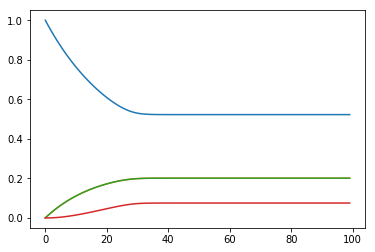

In [393]:
plt.plot(range(T), phi_t)

In [394]:
phi_t[-1]

array([0.52260743, 0.20105649, 0.20105649, 0.07527959])

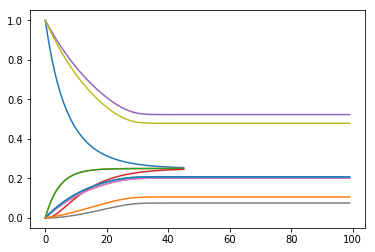

In [541]:
# as a limit



v = np.array([1, 0, 0, 0])
vs = [v]
#
t = 1
while sum(I[t]) < 0.9999:
    vs.append(P@vs[t-1])
    t += 1
    
plt.plot(range(t), vs)
#plt.plot(range(T), phi_t)
#plt.plot(range(T), anal_phi)

In [539]:
vs[-1]

array([0.25437487, 0.24998911, 0.24998911, 0.24564691])

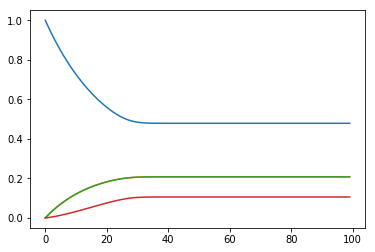

In [395]:
plt.plot(range(T), anal_phi)

In [396]:
anal_phi[-1]

array([0.47868606, 0.20772986, 0.20772986, 0.10585423])

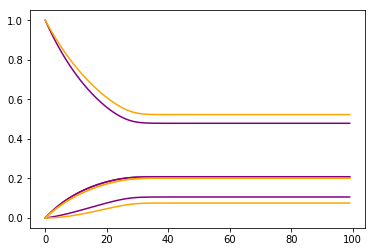

In [397]:
plt.plot(range(T), anal_phi, color='purple')
plt.plot(range(T), phi_t, color='orange')
#plt.xlim(0,5)
#plt.ylim(0.95,1)

# PHI V I

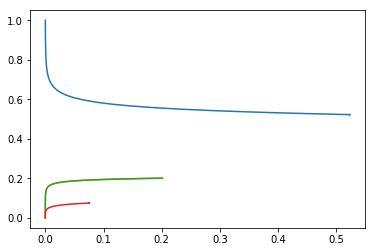

In [129]:
plt.plot(I, phi_t)

# Testing P

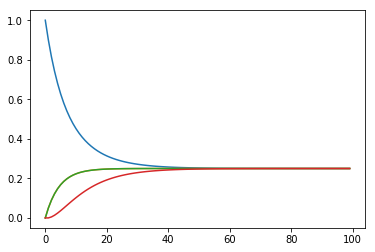

In [137]:
v = np.array([1, 0, 0, 0])
vs = [v]
#
for t in range(1,100):
    vs.append(P@vs[t-1])
    
plt.plot(range(100), vs)

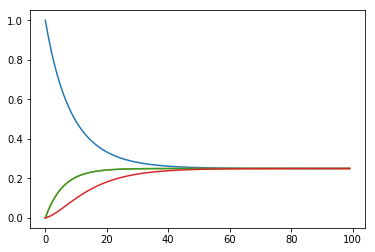

In [142]:
v = np.array([1, 0, 0, 0])
vs = [v]
#
for t in range(1,100):
    vs.append(vs[t-1] + (np.linalg.matrix_power(P,2) - P) @ vs[t-1])
    
plt.plot(range(100), vs)
#plt.xlim(0,10)

In [136]:
(np.linalg.matrix_power(P,2) - P)

array([[-0.085,  0.04 ,  0.04 ,  0.005],
       [ 0.04 , -0.085,  0.005,  0.04 ],
       [ 0.04 ,  0.005, -0.085,  0.04 ],
       [ 0.005,  0.04 ,  0.04 , -0.085]])

In [ ]:
# Investigating dphi

In [229]:
sweep_P = list()

for i in range(100):
    err = i/100
    M = (1-err)*np.eye(4) + err/2*A
    sweep_P.append(M @ (M-1) @ np.array([1,0,0,0]))

In [232]:
sweep_P[64] @  np.array([1,0,0,0])

-0.6656

In [247]:
sweep_P[67]

array([-0.66665, -0.7789 , -0.7789 , -0.77555])

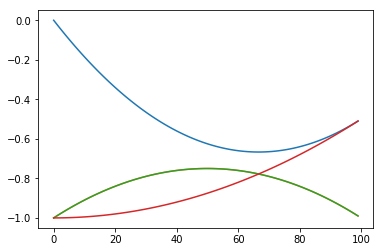

In [230]:
plt.plot(range(100), sweep_P)

In [368]:
phi_t = list()
I = [np.array([1/N,0,0,0])]
anal_phi = [np.array([1.,0.,0.,0.])]


for t in range(1,T):
    I.append(I[t-1] + dim(infected=I[t-1], beta=beta, k=avg_k, P=P))
    #anal_phi.append(I[t-1] + dphi(infected=I[t-1], beta=beta, k=4, P=P))
    anal_phi.append(anal_phi[t-1] + dphi_phi(infected=I[t-1], last_phi=anal_phi[t-1], beta=beta, k=avg_k, P=P))
    
homogenous_entropy = list()
    
for t in range(T):
    d = I[t]
    d = d/sum(d)
    p = d
    phi_t.append(p)

In [371]:
I[:5]

[array([0.0001, 0.    , 0.    , 0.    ]),
 array([1.359964e-04, 1.999800e-06, 1.999800e-06, 0.000000e+00]),
 array([1.85028231e-04, 5.43917443e-06, 5.43917443e-06, 7.99808014e-08]),
 array([2.51842863e-04, 1.10983321e-05, 1.10983321e-05, 3.26292584e-07]),
 array([3.42925231e-04, 2.01346349e-05, 2.01346349e-05, 8.87537171e-07])]

In [399]:
[i/sum(I[1]) for i in I[1]]

[0.9714306123032086, 0.014284693848395667, 0.014284693848395667, 0.0]

In [369]:
phi_t[:5]

[array([1., 0., 0., 0.]),
 array([0.97143061, 0.01428469, 0.01428469, 0.        ]),
 array([9.44086321e-01, 2.77527930e-02, 2.77527930e-02, 4.08093296e-04]),
 array([0.91790903, 0.04045086, 0.04045086, 0.00118926]),
 array([0.89284371, 0.05242275, 0.05242275, 0.0023108 ])]

In [370]:
anal_phi[:5]

[array([1., 0., 0., 0.]),
 array([0.9660034, 0.0159984, 0.0159984, 0.0019998]),
 array([0.93367976, 0.03097241, 0.03097241, 0.00437543]),
 array([0.90294054, 0.04498742, 0.04498742, 0.00708461]),
 array([0.87370235, 0.05810463, 0.05810463, 0.01008839])]

In [372]:
tinfected = I[0]
sumI = sum(tinfected)

In [390]:
tinfected

array([0.0001, 0.    , 0.    , 0.    ])

In [503]:
ti = P @ (0.1 * 4 * (1-sumI) * tinfected) #- tinfected 
sum(ti)
#0.1 * 4 * (1-sumI) * sumI + sumI
#fulli = ti + tinfected
#sum(ti)
#[i/sum(fulli) for i in ti]
#[i/sum(tinfected) for i in ti]

3.999600000000001e-05

In [504]:
sumI = sum(tinfected)
tphi = 0.1 * 4 * (1-sumI) * ((P-np.eye(P.shape[0]))) @ anal_phi[0]
#tphi = 0.1 * 4 * (1-sumI) * ((P @ anal_phi[0]) - anal_phi[0])
#tphi
#sumI
tphi #+ anal_phi[0]

array([-0.039996,  0.019998,  0.019998,  0.      ])

In [510]:
(0.1*4*(N-1)/N*0.1)

0.039996000000000004

In [511]:
P @ tinfected

array([9.e-05, 5.e-06, 5.e-06, 0.e+00])

In [ ]:
# Network as a function...